In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
import os
import pickle

In [37]:
train_dir = '/kaggle/working/final/train'
val_dir = '/kaggle/working/final/val'
test_dir = '/kaggle/working/final/test'
img_size = (60, 80)
batch_size = 128
num_classes = 4
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 35517 images belonging to 4 classes.
Found 4438 images belonging to 4 classes.


In [39]:
weights_path = '/kaggle/input/imagenet/tensorflow2/resnet/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [40]:
base_model = ResNet50(weights=weights_path, include_top=False, input_shape=(60, 80, 3))

# Freeze all layers in the base model except the last 4 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False


In [41]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)


In [42]:
model = Model(inputs=base_model.input, outputs=predictions)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [45]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    verbose=1
)
# Now you can use the history variable to access training/validation accuracies and losses
print(history.history.keys())

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


278/278 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.8526 - loss: 0.4670 - val_accuracy: 0.8396 - val_loss: 0.4978
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.9467 - loss: 0.2211 - val_accuracy: 0.9459 - val_loss: 0.2026
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 590s 2s/step - accuracy: 0.9550 - loss: 0.1778 - val_accuracy: 0.9468 - val_loss: 0.1984
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.9629 - loss: 0.1504 - val_accuracy: 0.9619 - val_loss: 0.1452
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.9663 - loss: 0.1334 - val_accuracy: 0.9617 - val_loss: 0.1390
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.9718 - loss: 0.1131 - val_accuracy: 0.9529 - val_loss: 0.1583
Epoch 7/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.9719 - loss: 0.1092 - val_accuracy: 0.9721 - val_loss: 0.1061
Epoch 8/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.9724 - loss: 0.1003 - val_accuracy: 0.966

In [46]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)

loss, accuracy = model.evaluate(test_generator, verbose=1)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Found 4444 images belonging to 4 classes.
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 898ms/step - accuracy: 0.9710 - loss: 0.1096
Test Loss: 0.11029869318008423
Test Accuracy: 0.9696219563484192


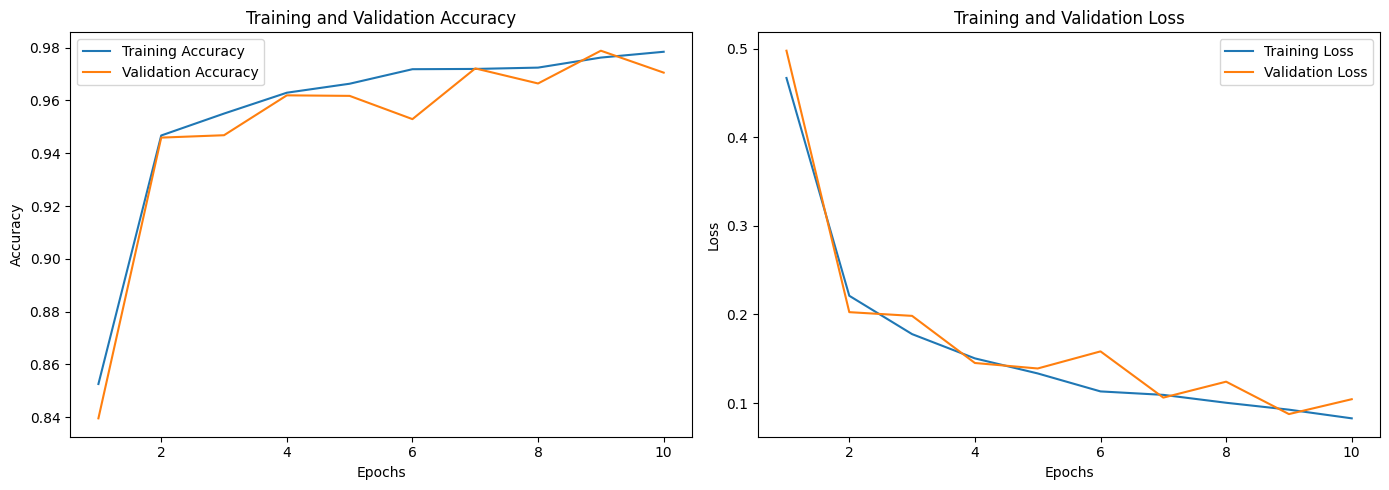

In [1]:
import matplotlib.pyplot as plt


epochs = range(1, 11)
accuracy = [0.8526, 0.9467, 0.9550, 0.9629, 0.9663, 0.9718, 0.9719, 0.9724, 0.9762, 0.9784]
val_accuracy = [0.8396, 0.9459, 0.9468, 0.9619, 0.9617, 0.9529, 0.9721, 0.9664, 0.9788, 0.9705]
loss = [0.4670, 0.2211, 0.1778, 0.1504, 0.1334, 0.1131, 0.1092, 0.1003, 0.0925, 0.0827]
val_loss = [0.4978, 0.2026, 0.1984, 0.1452, 0.1390, 0.1583, 0.1061, 0.1241, 0.0875, 0.1043]


plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
